<a href="https://colab.research.google.com/github/janchorowski/dl_uwr/blob/summer2021/Assignments/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1

**Submission deadlines:** 
- get at least 4 points by Tuesday, 9.03.2021
- remaining points: last lab session before or on Tuesday, 16.03.2021

**Points:** Aim to get 8 out of 12 possible points

## Submission instructions
The class is held remotely. To sumbmit your solutions please show the notebook over the video call. Make sure you know all the questions and asnwers, and that the notebook contains results (before presentation do `Runtime -> Restar and run all`)

We provide starter code, however you are not required to use it as long as you properly solve the tasks.

As always, please submit corrections using GitHub's Pull Requests to https://github.com/janchorowski/dl_uwr.

# Task description

## TLDR
Implement and train a neural network using pure numpy.


## Problem 1 [2p]
Implement a two-layer network, manually set weights and biases to solve the XOR task.

## Problem 2 [2p]
1. Add a backward pass.
2. Use a sensible random initialization for weights and biases.
3. Numerically check the correctness of your gradient computation.


## Problem 3 [2p]
1. Implement gradient descent
2. Train your network to solve 3D XOR
3. Try several hidden layer sizes, for each size record the fracton of successful trainings. Then answer:
    - What is the minimal hidden size required to solve 3D XOR (even with low reliability, when the training has to be repeated multiple times)
    - What is the minimal hidden size required to reliably solve 3D XOR
    - Which networks are easier to train - small or lare ones? Why?


## Problem 4 [1p]
Replace the first nonlinearity with the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation function. Find a network architecture which reliably learns the 3D XOR problem.


## Problem 5 [1p]
Add a second hidden layer to your network, implement the forward and backward pass, then demonstrate training.


## Problem 6 [2p]
Implement a way to have a _variable number_ of hidden layers. Check how deep digmoid or ReLU networks you  can train. For simplicity you can assume that all hidden layers have the same number of neurons, and use the same activation function.


## Problem 7 [2p]
For each weight matrix $w\in\mathbb{R}^{n\times m}$, add a randomly initialized `backward weight` $w_b\in\mathbb{R}^{m\times n}$, which will not change during training. Change the backward pass to use $w_b$ instead of $w^T$, getting an approxmatoin of the true gradient. Can you get your network to train?

NB: this approach, dubbed [feedback alignment](https://www.nature.com/articles/ncomms13276), was proposed to make error backpropagation more biologically plausible, by providing a solution to the "weight transport problem". Regular backpropagation requires that neurons not only know their incoming weights (thet they control), but also their outgoing weights (that are controlled by neurons in the upper layers). This is nearly impossible in a real brain.

# Solutions and starter code

In [1]:
import matplotlib.pyplot as plt
import numpy as np

XOR dataset creation

(-0.05, 1.05, -0.05, 1.05)

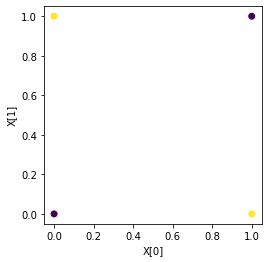

In [2]:
# Let's define a XOR dataset

# X will be matrix of N 2-dimensional inputs
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1],], dtype=np.float32)
# Y is a matrix of N numners - answers
Y = np.array([[0], [1], [1], [0],], dtype=np.float32)

plt.scatter(
    X[:, 0], X[:, 1], c=Y[:, 0],
)
plt.xlabel("X[0]")
plt.ylabel("X[1]")
plt.axis("square")

## Problem 1

The code below contains a mock-up of a two-layer neural network. Fill in the code and manually set weights to solve the XOR problem.

Please note: the shapes are set to be compatible with PyTorch's conventions:
* a batch containing $N$ $D$-dimensional examples has shape $N\times D$ (each example is a row!)
* a weight matrix in a linear layer with $I$ inputs and $O$ outputs has shape $O \times I$
* a bias vector is a 1D vector. Please note that [broadcasting rules](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) allow us to think about it as a $1 \times D$ matrix.

In [113]:
def sigmoid(x):
    return 1/(1+np.exp(-x))


class SmallNet:
    def __init__(self, in_features, num_hidden, dtype=np.float32):
        self.W1 = np.zeros((num_hidden, in_features), dtype=dtype)
        self.b1 = np.zeros((num_hidden,), dtype=dtype)
        self.W2 = np.zeros((1, num_hidden), dtype=dtype)
        self.b2 = np.zeros((1,), dtype=dtype)
        self.num_hidden=num_hidden
        self.in_features=in_features
        self.init_params()

    def init_params(self):
        # TODO for Problem 2:
        # set all parameters to small random values, e.g. from N(0, 0.5)
        odchStd=np.sqrt(0.5)
        self.W1=np.random.randn(self.num_hidden, self.in_features)/odchStd
        self.b1=np.random.randn(self.num_hidden)/odchStd
        self.W2=np.random.randn(1,self.num_hidden)/odchStd
        self.b2=np.random.randn(1)/odchStd

    def forward(self, X, Y=None, do_backward=False):
        # TODO Problem 1: Fill in details of forward propagation

        # Input to neurons in 1st layer
        A1 = X @ self.W1.T + self.b1               #(N, num_hidden)
        # wyjściem jest N x num_hidden, 
        # a więc pobudzenie każdego neurona z danej warstwy przez kolejne próbki
        # Outputs after the sigmoid non-linearity
        O1 = sigmoid(A1)                           #(N, num_hidden)
        # Inputs to neuron in the second layer
        A2 = O1 @ self.W2.T + self.b2              #(N, 1)
        # Outputs after the sigmoid non-linearity
        O2 = sigmoid(A2)                           #(N, 1)

        # When Y is none, simply return the predictions. Else compute the loss
        if Y is not None:
            loss = -Y * np.log(O2) - (1 - Y) * np.log(1.0 - O2)
            # normalize loss by batch size
            loss = loss.sum() / X.shape[0]
        else:
            loss = np.nan

        if do_backward:
            # TODO in Problem 2:
            # fill in the gradient computation
            # Please note, thate there is a correspondance between
            # the forward and backward pass: with backward computations happening
            # in reverse order.
            # We save the gradients with respect to parameters as fields of self.
            # It is not very elegant, but simplifies training code later on.

            # A2_grad is the gradient of loss with respect to A2
            # Hint: there is a concise formula for the gradient
            # of logistic sigmoid and cross-entropy loss
            N=A2.shape[0]
            A2_grad = O2-Y #O2 = sigmoid(A2)     # (N, 1)
            self.b2_grad = A2_grad.mean(0)
            self.W2_grad = A2_grad.T @ O1 / N    #(1, num_hidden)
            O1_grad = A2_grad @ self.W2 #(N, num_hid)
            A1_grad = O1_grad @ np.diag(np.mean(O1*(1-O1), axis=0))
            self.b1_grad = A1_grad.mean(0)
            self.W1_grad = A1_grad.T @ X /N
        return O2, loss

In [35]:
# TODO Problem 1:
# Set by hand the weight values to solve the XOR problem

net = SmallNet(2, 2, dtype=np.float64)
net.W1 = np.array([[100,100],[100,100]], dtype=np.float64)
net.b1 = np.array([-150,-50], dtype=np.float64)
net.W2 = np.array([[-200,100]], dtype=np.float64)
net.b2 = np.array([-50], dtype=np.float64)

# Hint: since we use the logistic sigmoid activation, the weights may need to
# be fairly large


predictions, loss = net.forward(X, Y, do_backward=False)
for x, p in zip(X, predictions):
    print(f"XORnet({x}) = {p[0]}")

XORnet([0. 0.]) = 1.928749847963918e-22
XORnet([0. 1.]) = 1.0
XORnet([1. 0.]) = 1.0
XORnet([1. 1.]) = 7.175095973164411e-66


<ipython-input-34-1e38a0ded752>:40: RuntimeWarning: divide by zero encountered in log
  loss = -Y * np.log(O2) - (1 - Y) * np.log(1.0 - O2)
<ipython-input-34-1e38a0ded752>:40: RuntimeWarning: invalid value encountered in multiply
  loss = -Y * np.log(O2) - (1 - Y) * np.log(1.0 - O2)


## Problem 2

In [29]:
def check_grad(net, param_name, X, Y, eps=1e-5):
    """A gradient checking routine"""

    param = getattr(net, param_name)
    param_flat_accessor = param.reshape(-1)

    grad = np.empty_like(param)
    grad_flat_accessor = grad.reshape(-1)

    net.forward(X, Y, do_backward=True)
    orig_grad = getattr(net, param_name + "_grad")
    assert param.shape == orig_grad.shape

    for i in range(param_flat_accessor.shape[0]):
        orig_val = param_flat_accessor[i]
        param_flat_accessor[i] = orig_val + eps
        _, loss_positive = net.forward(X, Y)
        param_flat_accessor[i] = orig_val - eps
        _, loss_negative = net.forward(X, Y)
        param_flat_accessor[i] = orig_val
        grad_flat_accessor[i] = (loss_positive - loss_negative) / (2 * eps)
    print(grad)
    print(orig_grad)
    assert np.allclose(grad, orig_grad)
    return grad, orig_grad

In [114]:
net = SmallNet(2, 2, dtype=np.float64)
check_grad(net, "W1", X, Y)

AssertionError: 

In [37]:
# Hint: use float64 for checking the correctness of the gradient
net = SmallNet(2, 2, dtype=np.float64)

for param_name in ["W1", "b1", "W2", "b2"]:
    print(param_name)
    check_grad(net, param_name, X, Y)

W1
[[ 0.01558026  0.01478179]
 [-0.01519971  0.00940729]]
[[ 0.41155943  0.41155943]
 [-0.47695778 -0.47695778]]


AssertionError: 

## Problem 3

In [88]:
net = SmallNet(2, 10, dtype=np.float64)

alpha = 1  # set a learning rate

for i in range(100001):
    _, loss = net.forward(X, Y, do_backward=True)
    if (i % 5000) == 0:
        print(f"after {i} steps \tloss={loss}")
    for param_name in ["W1", "b1", "W2", "b2"]:
        param = getattr(net, param_name)
        # Hint: use the construct `param[:]` to change the contents of the array!
        # Doing instead `param = new_val` simply changes to what the variable
        # param points to, without affecting the network!
        # alternatively, you could do setattr(net, param_name, new_value)
        param[:] = param - alpha * getattr(net, param_name + "_grad")


after 0 steps 	loss=0.8429345157318557
after 5000 steps 	loss=0.5174908852985718
after 10000 steps 	loss=0.4610807676756279
after 15000 steps 	loss=0.5106598829458331
after 20000 steps 	loss=0.4831157615256478
after 25000 steps 	loss=0.4689533361336571
after 30000 steps 	loss=0.48353248979105184
after 35000 steps 	loss=0.4064569382377895
after 40000 steps 	loss=0.37037255775543526
after 45000 steps 	loss=0.3366842097972269
after 50000 steps 	loss=0.4791993829705914
after 55000 steps 	loss=0.446833121897284
after 60000 steps 	loss=0.3364807544092125
after 65000 steps 	loss=0.4303359503709031
after 70000 steps 	loss=0.5263580951662576
after 75000 steps 	loss=0.501255330139714
after 80000 steps 	loss=0.5095916716608777
after 85000 steps 	loss=0.5053375140448162
after 90000 steps 	loss=0.5096392871965287
after 95000 steps 	loss=0.49804476223242555
after 100000 steps 	loss=0.4392745054454663


In [89]:
predictions, loss = net.forward(X, Y, do_backward=True)
for x, p in zip(X, predictions):
    print(f"XORnet({x}) = {p[0]}")

XORnet([0. 0.]) = 0.3948855521971022
XORnet([0. 1.]) = 0.68346205482441
XORnet([1. 0.]) = 0.6811108646517222
XORnet([1. 1.]) = 0.4028208102910468


In [93]:
# TODO:
# Generate data for a 3D XOR task
# Then estimate the sucess rate of training the network with diferent
# hidden sizes.

X3 = np.array([[0,0,0],[0,0,1],[0,1,0],[0,1,1],[1,0,0],[1,0,1],[1,1,0],[1,1,1]], dtype=np.float64)
Y3 = np.array([0,1,1,0,1,0,0,1], dtype=np.float64).reshape((-1,1))

alpha=1

for hidden_dim in [2, 3, 5, 10, 20]:
    net = SmallNet(3, hidden_dim, dtype=np.float64)
    predictions, loss = net.forward(X3, Y3, do_backward=True)
    for i in range(100001):
        _, loss = net.forward(X3, Y3, do_backward=True)
        if (i % 20000) == 0:
            print(f"after {i} steps \tloss={loss}")
        for param_name in ["W1", "b1", "W2", "b2"]:
            param = getattr(net, param_name)
            param[:] = param - alpha * getattr(net, param_name + "_grad")
    print(f"For {hidden_dim} neurons in hidden layer we got {loss} loss result")

after 0 steps 	loss=1.3219631971987247
after 20000 steps 	loss=0.6931465931621918
after 40000 steps 	loss=0.6931465884346619
after 60000 steps 	loss=0.6931465837435056
after 80000 steps 	loss=0.6931465790887013
after 100000 steps 	loss=0.6931465744702249
For 2 neurons in hidden layer we got 0.6931465744702249 loss result
after 0 steps 	loss=1.0099660989197057
after 20000 steps 	loss=0.692895639585138
after 40000 steps 	loss=0.6930099219734709
after 60000 steps 	loss=0.6930510518326881
after 80000 steps 	loss=0.6930699153353446
after 100000 steps 	loss=0.6930805475370525
For 3 neurons in hidden layer we got 0.6930805475370525 loss result
after 0 steps 	loss=1.8051867996510802
after 20000 steps 	loss=0.6928277699841362
after 40000 steps 	loss=0.6923315373588115
after 60000 steps 	loss=0.6924218939637232
after 80000 steps 	loss=0.6919768731721676
after 100000 steps 	loss=0.6918151869004912
For 5 neurons in hidden layer we got 0.6918151869004912 loss result
after 0 steps 	loss=1.1451458196

## Problem 4


## Problem 5

## Problem 6

## Problem 7